In [19]:
# install dependencies
# use pip and virtualenv
!python --version
!pip install nltk matplotlib prettytable tqdm
!pip install langchain_community langchain-huggingface langchain-chroma chromadb==0.5.5 sentence_transformers

Python 3.10.12


In [20]:
# global vars
TRAINING_DATA_PATH = "training_data.local/"

# import libraries
try:
    from langchain_core.documents import Document
    from langchain_community.document_loaders import DirectoryLoader, TextLoader
    from langchain_text_splitters import RecursiveCharacterTextSplitter as rts
    from langchain_text_splitters import NLTKTextSplitter as nts
    from prettytable import PrettyTable
    from langchain_chroma import Chroma
    from chromadb import Client
    import uuid
    from tqdm.autonotebook import tqdm, trange
    from nltk import word_tokenize, sent_tokenize, download
    import os
    download("punkt")
    import matplotlib.pyplot as plt
except Exception as e:
    print(f"Caught Exception {e}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [21]:
# Text Processing Primitives
# Embedding function
def s_transformer(model: str = "all-MiniLM-L6-v2", hf=False):
  if hf is True:
    from langchain_huggingface import HuggingFaceEmbeddings as hfe
    return hfe(model_name=model)
  else:
    from chromadb.utils import embedding_functions as ef
    return ef.SentenceTransformerEmbeddingFunction(model_name=model)

# load text documents from filesystem
def load_text_documents(path: str = ".", pattern: str = "**/*.txt",
                        multithread: bool = False) -> list:
    loader = DirectoryLoader(path,
                             glob=pattern,
                             loader_cls=TextLoader,
                             loader_kwargs={'autodetect_encoding': True},
                             use_multithreading=multithread,
                             silent_errors=True,
                             show_progress=True)
    return loader.load()

# prepare the knowledge corpus for further processing
def prepare_corpus(raw_loader: list) -> list:
    # collect statistics in relation to the data corpus
    metadata = []
    for doc in raw_loader:
        document_tokens = word_tokenize(doc.page_content)
        document_sentences = sent_tokenize(doc.page_content)
        metadata.append({"metadata": doc.metadata,
                       "raw_sentences": document_sentences,
                       "page_contents": doc.page_content,
                       "sentence_count": len(document_sentences),
                       "wordcount": len(document_tokens),
                       "vocabulary": set(document_tokens),
                       "lexical_richness": len(set(document_tokens)) / len(document_tokens)})

    # display corpus
    data_table = PrettyTable()
    data_table.field_names = ["Dataset", "Word Count", "Sentence Count", "Vocabulary", "Lexical Richness"]
    for dataset in metadata:
        data_table.add_row([dataset.get("metadata").get("source"), dataset.get("wordcount"), dataset.get("sentence_count"), len(dataset.get("vocabulary")), dataset.get("lexical_richness")])

    # display dataset statistics
    print(data_table)

    # return processed data
    corpus_data = []
    for doc in tqdm(metadata, ascii=True, desc="Loading..."):
        doc_metadata = doc.get("metadata")
        corpus_data.append(Document(metadata=doc_metadata, page_content=doc.get("page_contents")))

    # return corpus and metadata
    return corpus_data, metadata

# split corpus in chunks for vectorization
def split_text_documents_recursive(documents: list = None,
                         chunk_size: int = 1000,
                         chunk_overlap: int = 0) -> list:
    if documents is None:
        return None

    splitter = rts(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    return splitter.split_documents(documents)

# split corpus using NLTK
def split_text_documents_nltk(documents: list = None,
                              separator: str = '\n\n',
                              language: str = 'english') -> list:
    if documents is None:
      return None

    splitter = nts(separator=separator, language=language)
    return splitter.split_documents(documents)

In [22]:
# walk the raw data storage path and search for text documents
raw_loader = load_text_documents(TRAINING_DATA_PATH)

# collect statistics in relation to the data corpus
corpus_data, metadata = prepare_corpus(raw_loader)

100%|██████████| 6/6 [00:00<00:00, 139.20it/s]


+--------------------------------------+------------+----------------+------------+---------------------+
|               Dataset                | Word Count | Sentence Count | Vocabulary |   Lexical Richness  |
+--------------------------------------+------------+----------------+------------+---------------------+
|   training_data.local/mobydick.txt   |   259367   |      9184      |   22234    | 0.08572408980325176 |
|    training_data.local/alice.txt     |   38047    |      1105      |    3871    | 0.10174258154387994 |
| training_data.local/frankenstein.txt |   88761    |      3199      |    8162    | 0.09195479996845461 |
|   training_data.local/rfc6248.txt    |    1649    |       68       |    528     | 0.32019405700424497 |
|    training_data.local/facts.txt     |    107     |       7        |     68     |  0.6355140186915887 |
|   training_data.local/rfc2104.txt    |    3755    |      139       |    929     |  0.2474034620505992 |
+--------------------------------------+------

Loading...:   0%|          | 0/6 [00:00<?, ?it/s]

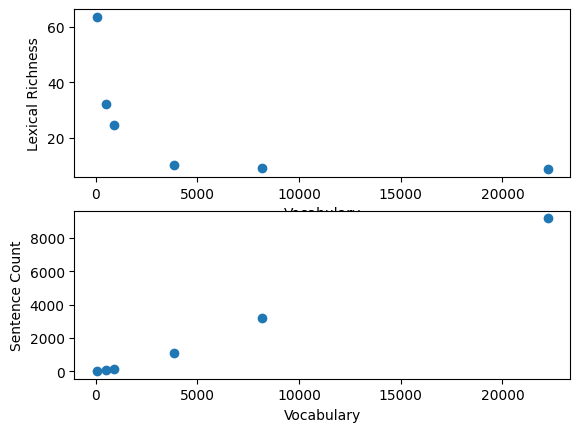

In [23]:
# plot dataset statistics graph
x_vals = [len(x.get("vocabulary")) for x in metadata]
y_vals = [100 * x.get("lexical_richness") for x in metadata]
y2_vals = [x.get("sentence_count") for x in metadata]

# plot vocabulary vs richness data
plt.subplot(211)
plt.ylabel("Lexical Richness")
plt.xlabel("Vocabulary")
plt.scatter(x_vals, y_vals)
# plot sentence count vs vocabulary
plt.subplot(212)
plt.ylabel("Sentence Count")
plt.xlabel("Vocabulary")
plt.scatter(x_vals, y2_vals)
plt.show()

In [24]:
# prepare data for further tokenization
CHUNK_SIZE = 2000 # 1000 words per chunk
OVERLAP = 200 # overlapping words, avoid missing context and splitting sentences
SEPARATOR='\n\n'
TEXT_LANGUAGE='english'

# split documents (recursive)
tokenized_docs_recursive = split_text_documents_recursive(corpus_data, chunk_size=CHUNK_SIZE, chunk_overlap=OVERLAP)

# split documents (NLTK)
tokenized_docs_nltk = split_text_documents_nltk(corpus_data, separator=SEPARATOR, language=TEXT_LANGUAGE)

print(f"Tokenized {len(tokenized_docs_recursive)} documents via Recursive Splitter...")
print(f"Tokenized {len(tokenized_docs_nltk)} documents via NLTK Splitter...")

# remove buffers
del(raw_loader)
del(corpus_data)
del(metadata)

Tokenized 1199 documents via Recursive Splitter...
Tokenized 501 documents via NLTK Splitter...


In [25]:
# now call the embedding model and upload data to the vector database
SIMILARITY_FUNCTION = "cosine"
COLLECTION_NAME = "rag_demo"
os.environ['HF_HOME'] = '/tmp/huggingface/hub/'

# connect to a running chroma instance
try:
    vector_store_client = Client()
    chroma_collection = vector_store_client.get_or_create_collection(COLLECTION_NAME,
                                                              metadata={"hnsw:space": SIMILARITY_FUNCTION})
except Exception as e:
    print(f"Caught Exception: {e}")

In [26]:
# create a wrapper around the ChromaDB client to use via LangChain
chroma_langchain_adapter = Chroma(client=vector_store_client, collection_name=COLLECTION_NAME, embedding_function=s_transformer(hf=True))

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [27]:
# embed data and push vectors to the database (NLTK tokens)
if len(tokenized_docs_nltk) > 0:
  #chroma_collection.add(ids=[str(uuid.uuid1()) for doc in tokenized_docs], documents=[doc.page_content for doc in tokenized_docs], metadatas=[doc.metadata for doc in tokenized_docs])
    for doc in tqdm(tokenized_docs_nltk, ascii=True, desc="Ingesting..."):
      chroma_langchain_adapter.add_documents(ids=[str(uuid.uuid1())], documents=[doc])

Ingesting...:   0%|          | 0/501 [00:00<?, ?it/s]

In [28]:
# define query example
QUERY_TEXT="describe the HMAC algorithm as written in RFC2104"

# explore the vector collection
print(f"Objects stored in the collection {chroma_collection.name}: {chroma_collection.count()}")
chroma_collection.query(query_texts=[QUERY_TEXT], n_results=1)

# query via LangChain
results = chroma_langchain_adapter.similarity_search_with_score(
  QUERY_TEXT, k=5,
)

# build a vector table
retrieved_docs = {}
for res, score in results:
  retrieved_docs[score] = res
  print(f"* {score:3f} - [{res.metadata}]")

# now get the result with the higher similarity (lower score = more similarity)
best_doc_by_similarity_score = retrieved_docs[min(retrieved_docs.keys())]
print(f"BEST DOCUMENT - Score {min(retrieved_docs.keys())} - {best_doc_by_similarity_score.metadata}")

Objects stored in the collection rag_demo: 1002
* 0.399421 - [{'source': 'training_data.local/rfc2104.txt'}]
* 0.399421 - [{'source': 'training_data.local/rfc2104.txt'}]
* 0.403106 - [{'source': 'training_data.local/rfc2104.txt'}]
* 0.403106 - [{'source': 'training_data.local/rfc2104.txt'}]
* 0.433365 - [{'source': 'training_data.local/rfc2104.txt'}]
BEST DOCUMENT - Score 0.39942121505737305 - {'source': 'training_data.local/rfc2104.txt'}


In [29]:
del chroma_langchain_adapter
vector_store_client.delete_collection(COLLECTION_NAME)